## Loading data

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import lmfit
from tqdm.auto import tqdm
import pickle
import joblib

# import required packages
import os
import scipy.io as sio
from pymcmcstat.MCMC import MCMC
from pymcmcstat.plotting import MCMCPlotting
from pymcmcstat import mcmcplot as mcp
import pymcmcstat
print(pymcmcstat.__version__)
np.seterr(over='ignore');

1.9.1


In [2]:
df = pd.read_csv('worldometer_coronavirus_daily_data.csv', parse_dates=['date'], encoding='cp1251')
df

,date,country,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
0,2020-02-15,Afghanistan,0.0,NaN,0.0,0.0,NaN
1,2020-02-16,Afghanistan,0.0,NaN,0.0,0.0,NaN
2,2020-02-17,Afghanistan,0.0,NaN,0.0,0.0,NaN
3,2020-02-18,Afghanistan,0.0,NaN,0.0,0.0,NaN
4,2020-02-19,Afghanistan,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...
170912,2022-03-13,Zimbabwe,242515.0,158.0,4896.0,5414.0,0.0
170913,2022-03-14,Zimbabwe,242909.0,394.0,5068.0,5416.0,2.0
170914,2022-03-15,Zimbabwe,243365.0,456.0,5161.0,5417.0,1.0
170915,2022-03-16,Zimbabwe,243650.0,285.0,4968.0,5418.0,1.0


In [32]:
data = df.groupby(['date']).sum()

In [33]:
len(df.country.unique())

225

In [34]:
data

,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
date,,,,,
2020-01-22,571.0,0.0,554.0,17.0,0.0
2020-01-23,830.0,259.0,771.0,25.0,8.0
2020-01-24,1287.0,457.0,1208.0,41.0,16.0
2020-01-25,1975.0,688.0,1870.0,56.0,15.0
2020-01-26,2744.0,769.0,2613.0,80.0,24.0
...,...,...,...,...,...
2022-03-13,459055082.0,1474046.0,50675401.0,6065690.0,4185.0
2022-03-14,460313720.0,1258638.0,50026510.0,6070002.0,4312.0
2022-03-15,462031063.0,1717343.0,49784097.0,6075681.0,5679.0


In [23]:
data = df[df['country'] == 'Bolivia']

In [35]:
data.reset_index(inplace=True)

In [36]:
data.rename(columns={'daily_new_cases': 'CONFIRMED', 'active_cases': 'ACTIVE', 'daily_new_deaths': 'DEATHS', 'date': 'TIME'}, inplace=True)

In [37]:
data['RECOVERED'] = data['DEATHS']
data

,TIME,cumulative_total_cases,CONFIRMED,ACTIVE,cumulative_total_deaths,DEATHS,RECOVERED
0,2020-01-22,571.0,0.0,554.0,17.0,0.0,0.0
1,2020-01-23,830.0,259.0,771.0,25.0,8.0,8.0
2,2020-01-24,1287.0,457.0,1208.0,41.0,16.0,16.0
3,2020-01-25,1975.0,688.0,1870.0,56.0,15.0,15.0
4,2020-01-26,2744.0,769.0,2613.0,80.0,24.0,24.0
...,...,...,...,...,...,...,...
781,2022-03-13,459055082.0,1474046.0,50675401.0,6065690.0,4185.0,4185.0
782,2022-03-14,460313720.0,1258638.0,50026510.0,6070002.0,4312.0,4312.0
783,2022-03-15,462031063.0,1717343.0,49784097.0,6075681.0,5679.0,5679.0
784,2022-03-16,463898962.0,1867899.0,49699083.0,6081343.0,5662.0,5662.0


## Considering the first phase

In [38]:
data.fillna(0, inplace = True )

<AxesSubplot:>

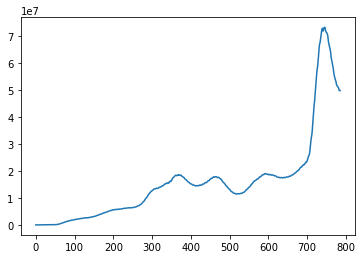

In [39]:
data.ACTIVE.plot()

In [40]:
active = data.ACTIVE

In [41]:
def phases(data_active):
    i = 30
    phases_begin_day = [0]
    while i< len(data_active):
        up_array = np.array([data_active[i]<j for j in data_active[i-30:i]]).mean()
        lo_array = np.array([data_active[i]<j for j in data_active[i:i+30]]).mean()
    #     print(up_array)
        if (up_array > 0.75) and (lo_array >0.75):
            phases_begin_day.append(i)
            i+=30
        else:
            i+=1      
    return phases_begin_day

In [42]:
phases(active)

[0, 411, 516, 629]

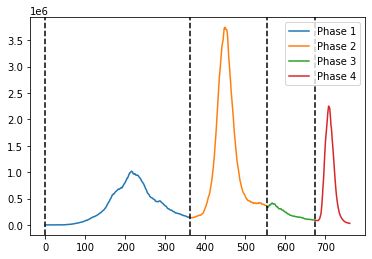

In [22]:
for i in range(len(phases(active))):
    try:
        active[phases(active)[i]:phases(active)[i+1]].plot(label = f'Phase {i+1}')
        plt.axvline(x=phases(active)[i],color='k', linestyle='--')

    except:
        active[phases(active)[i]:].plot(label = f'Phase {i+1}')
        plt.axvline(x=phases(active)[i], color='k', linestyle='--')
plt.legend()

In [131]:
def mh(df, intial_data, population):
    tx = np.arange(len(df))
    ty = df[['CONFIRMED', 'ACTIVE', 'RECOVERED' ]].values
    
    # Build a loss function (sum of squares)
    def covid_ss(theta, data):
        # sum-of-squares function for covid example
        ndp, nbatch = data.shape[0]
        time = tx
        ydata = ty
        xdata = data.user_defined_object[0]
        # last 3 parameters are the initial states
        y0 = x_initial
        # evaluate model
        tmodel, ymodel = covid_fun(time, theta, y0, xdata)
    #     a_model = np.cumsum(ymodel[:,2]-(ymodel[:,3]+ymodel[:,4]))
        res = ymodel[:,2] - ty[:,1]
        ss = (res**2).sum(axis=0)
        return ss  

    # Building SIERD model
    def covid_fun(time, theta, y0, xdata  = None):
        soln = odeint(covid_sys, y0, time, args=(theta, xdata))
    #     s, e, i, r = soln.T   
        return time, soln

    N = population
    S0, E0, I0, R0, D0 = intial_data

    x_initial = S0, E0, I0, R0, D0

    alpha_by_agegroup = {"0-29": 0.01, "30-59": 0.05, "60-89": 0.2, "89+": 0.3}
    proportion_of_agegroup = {"0-29": 0.1, "30-59": 0.3, "60-89": 0.4, "89+": 0.2}

    def covid_sys(y, t ,theta, xdata = None):
        S, E, I, R, D = y

        t_infective = theta[0]
        gamma = 1.0 / t_infective
        t_incubation = theta[1]
        delta = 1.0 / t_incubation
        R_0_start, k, x0, R_0_end = theta[2], theta[3], theta[4], theta[5]
        s = theta[6]
        alpha_opt = sum(alpha_by_agegroup[i] * proportion_of_agegroup[i] for i in list(alpha_by_agegroup.keys()))

        rho = theta[7]

        def alpha(t):
            return s * I/N + alpha_opt

        def logistic_R_0(t):
            return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

        def beta(t):
            return logistic_R_0(t) * gamma


    #     s, e, i, r = x
        dSdt = -beta(t) * S * I / N
        dEdt = beta(t) * S * I / N - delta * E
        dIdt = delta * E - (1 - alpha(t)) * gamma * I - alpha(t) * rho * I
        dRdt = (1 - alpha(t)) * gamma * I
        dDdt = alpha(t) * rho * I
        ydot = np.array([dSdt, dEdt, dIdt, dRdt, dDdt])
        return ydot





    
    # tx corresponds to the days, and ty to the active cases

    # initialize MCMC object
    mcstat = MCMC()
    # initialize data structure 
    mcstat.data.add_data_set(x=tx,
                             y=ty[:,:],
                             user_defined_object=tx)
    # initialize parameter array
    # add model parameters

    # initialize parameter array
    # add model parameters
    # Intially population o SPB is considered as 10000000 and all the intial parameters for SIERD model are defined
    mcstat.parameters.add_model_parameter(name='t_infective', theta0=4, minimum=0, maximum = 100)
    mcstat.parameters.add_model_parameter(name='t_incubation', theta0=5, minimum=0, maximum=100)
    mcstat.parameters.add_model_parameter(name='R_0_start', theta0=5, minimum=0, maximum=100)
    mcstat.parameters.add_model_parameter(name='k', theta0=0.5, minimum=0, maximum=1)
    mcstat.parameters.add_model_parameter(name='x0', theta0=50, minimum=0, maximum=100)
    mcstat.parameters.add_model_parameter(name='R_0_end', theta0=0.5, minimum=0, maximum=100)
    mcstat.parameters.add_model_parameter(name='s', theta0=0.05, minimum=0, maximum=1)
    mcstat.parameters.add_model_parameter(name='rho', theta0=0.1, minimum=0, maximum=100)





    # Generate options
    mcstat.simulation_options.define_simulation_options(nsimu=1.0e3, updatesigma=True)


    mcstat.model_settings.define_model_settings(
        sos_function=covid_ss)

    # Run simulation
    mcstat.run_simulation()
    # Rerun starting from results of previous run
    mcstat.simulation_options.nsimu = int(5.0e3)
    mcstat.run_simulation(use_previous_results=True)
    
    # extract info from results
    results = mcstat.simulation_results.results
    burnin = int(results['nsimu']/2)
    chain = results['chain'][burnin:, :]
    s2chain = results['s2chain'][burnin:, :]
    names = results['names'] # parameter names

    # display chain stats
    mcstat.chainstats(chain, results)

    settings = dict(
        fig=dict(figsize=(7, 6))
    )
    # plot chain panel
    mcp.plot_chain_panel(chain, names, settings)
    # plot density panel
    mcp.plot_density_panel(chain, names, settings)
    # pairwise correlation
    f = mcp.plot_pairwise_correlation_panel(chain, names, settings)

    
    return results['theta']

In [132]:
def metrics_and_plot(df, optimal_parameters, intial_data, population):
    m = optimal_parameters
    N = population
    D = m[0] # infections lasts four days
    gamma = 1.0 / D
    delta = 1.0 / m[1] # incubation period of five days

    R_0_start, k, x0, R_0_end = m[2:6]

    def logistic_R_0(t):
        return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

    def beta(t):
        return logistic_R_0(t) * gamma
    def deriv(y, t, N, beta, gamma, delta, alpha_opt, rho):
        S, E, I, R, D = y
        def alpha(t):
            return s * I/N + alpha_opt

        dSdt = -beta(t) * S * I / N
        dEdt = beta(t) * S * I / N - delta * E
        dIdt = delta * E - (1 - alpha(t)) * gamma * I - alpha(t) * rho * I
        dRdt = (1 - alpha(t)) * gamma * I
        dDdt = alpha(t) * rho * I
        return dSdt, dEdt, dIdt, dRdt, dDdt


    alpha_by_agegroup = {"0-29": 0.01, "30-59": 0.05, "60-89": 0.2, "89+": 0.3}
    proportion_of_agegroup = {"0-29": 0.1, "30-59": 0.3, "60-89": 0.4, "89+": 0.2}
    s = m[6]
    alpha_opt = sum(alpha_by_agegroup[i] * proportion_of_agegroup[i] for i in list(alpha_by_agegroup.keys()))

    rho = m[7] # 9 days from infection until death
    S0, E0, I0, R0, D0 = intial_data  # initial conditions: one exposed
    
    t = np.linspace(0, len(df)-1 , len(df)) # Grid of time points (in days)
    y0 = S0, E0, I0, R0, D0 # Initial conditions vector

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha_opt, rho))
    S, E, I, R, D = ret.T
    R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values
    Alpha_over_time = [s * I[i]/N + alpha_opt for i in range(len(t))]  # to plot alpha over time
    
#     plt.plot(t, I)
#     plt.plot(t, df.ACTIVE)
#     plt.show()
    r2score = r2_score(df['ACTIVE'], I )
    print(r2score)
    return r2score, [S[-1], E[-1], I[-1], R[-1], D[-1]], I

In [133]:
def whole_covid(data, population):
    N = population
    predictions = []
    active = data.ACTIVE
    phase = phases(active)
    intial_data = [N-1,1,0,0,0]
    for i in range(len(phase)):
        try:

            df = data[phase[i]:phase[i+1]]

            optimal_parameters = mh(df, intial_data, population)
            new_start_point = metrics_and_plot(df, optimal_parameters,intial_data, population)[1]
            predictions.extend(metrics_and_plot(df, optimal_parameters, intial_data, population)[2])

            intial_data = new_start_point
            print(metrics_and_plot(df, optimal_parameters, intial_data, population))
            print(intial_data)

        except:
            df = data[phase[i]:]

            optimal_parameters = mh(df, intial_data, population)
            new_start_point = metrics_and_plot(df, optimal_parameters,intial_data, population)[1]
            predictions.extend(metrics_and_plot(df, optimal_parameters, intial_data, population)[2])

            intial_data = new_start_point
            print(metrics_and_plot(df, optimal_parameters, intial_data, population))
            print(intial_data)
    return predictions


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
t_infective:      4.00 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
t_incubation:      5.00 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
 R_0_start:      5.00 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
         k:      0.50 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
        x0:     50.00 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
   R_0_end:      0.50 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
         s:      0.05 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
       rho:      0.10 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 1000 of 1000 complete in 14.5 sec
Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
t_infective:      6.53 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
t_incubation:      7.37 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
 R_0_start:     10.39 [ 0.00e+00,    100.00] 

 [-----------------100%-----------------] 1000 of 1000 complete in 10.4 sec
Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
t_infective:      6.11 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
t_incubation:      6.99 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
 R_0_start:      1.00 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
         k:      0.80 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
        x0:     70.29 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
   R_0_end:      0.96 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
         s:      0.08 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
       rho:      0.13 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 5000 of 5000 complete in 56.2 sec

------------------------------
      name:      mean       std    MC_err       tau    geweke
t_infective:      3.62      0.06  6.38e-03     44.72      1.00
t_incubation:      8.11      0.04  5.17e-03    1

 [-----------------100%-----------------] 1000 of 1000 complete in 6.0 sec
Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
t_infective:      4.92 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
t_incubation:      8.18 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
 R_0_start:      1.84 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
         k:  1.63e-03 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
        x0:     99.25 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
   R_0_end:      1.06 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
         s:      0.02 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
       rho:      0.17 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 5000 of 5000 complete in 33.9 sec

------------------------------
      name:      mean       std    MC_err       tau    geweke
t_infective:      1.74      0.14      0.03    186.19      0.89
t_incubation:     24.92      0.96      0.20    18

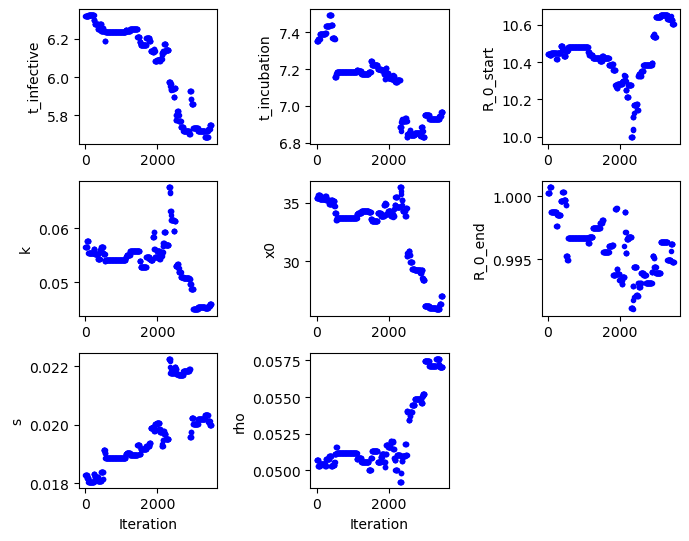

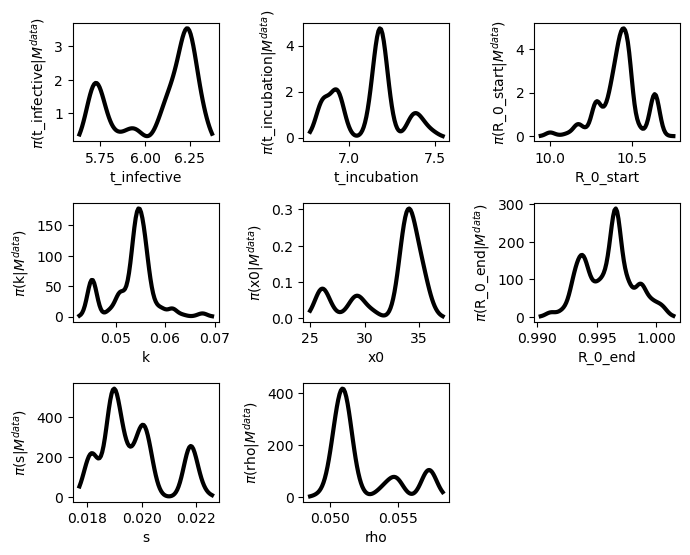

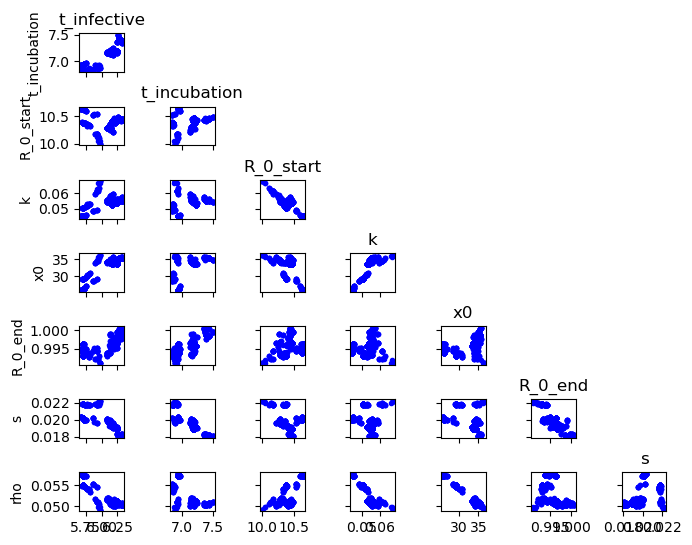

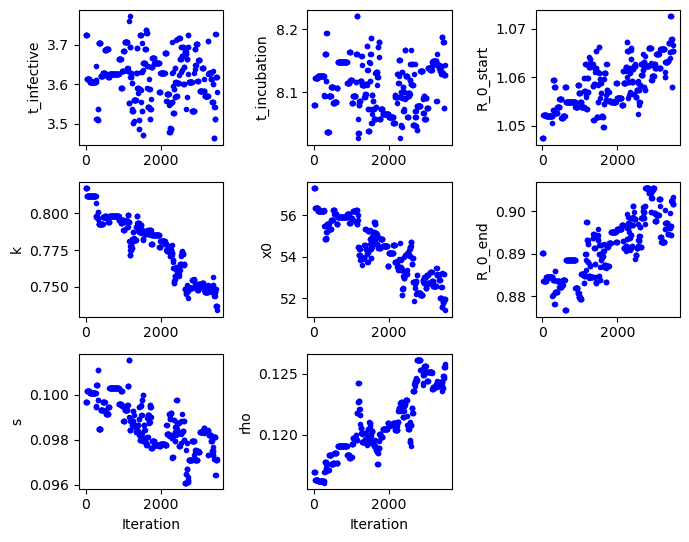

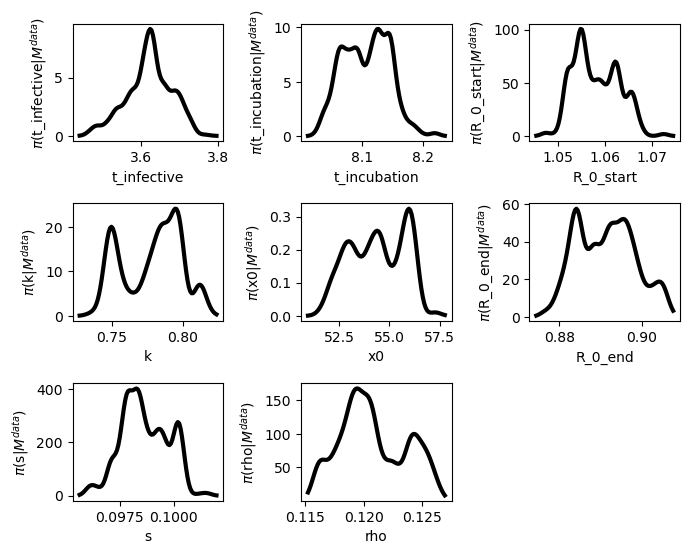

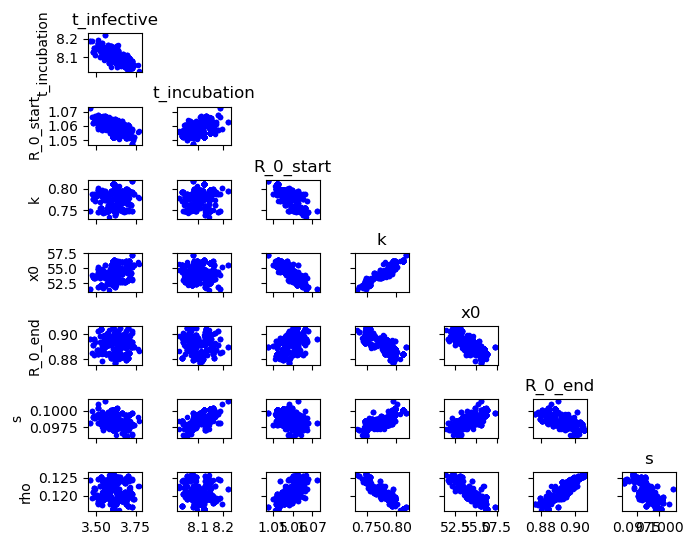

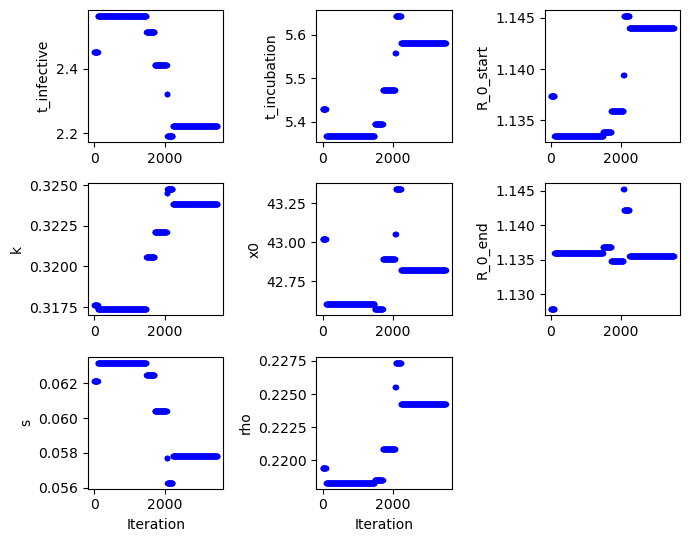

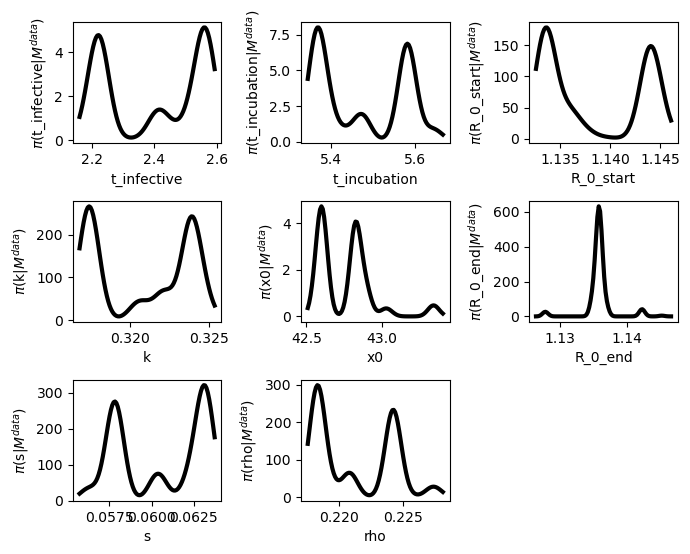

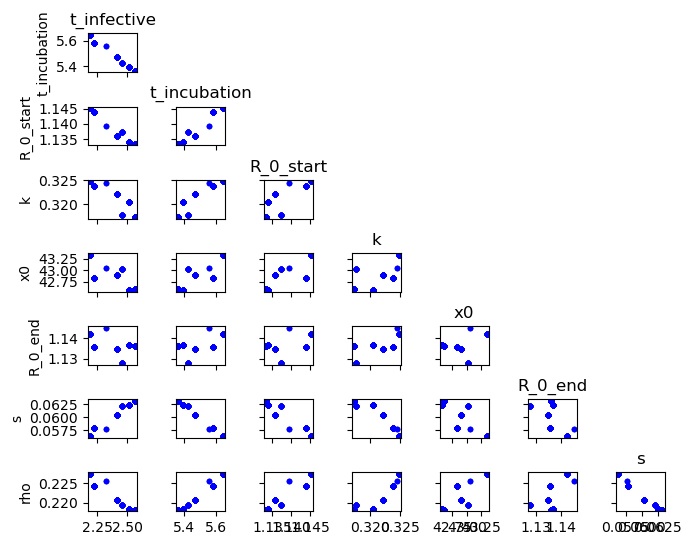

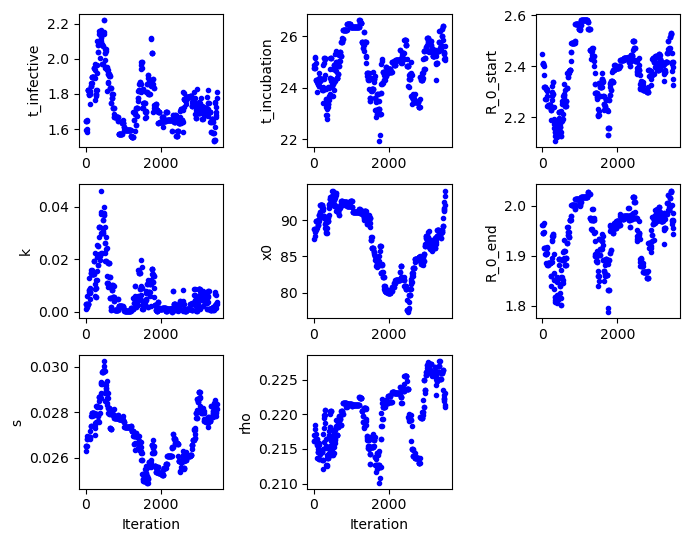

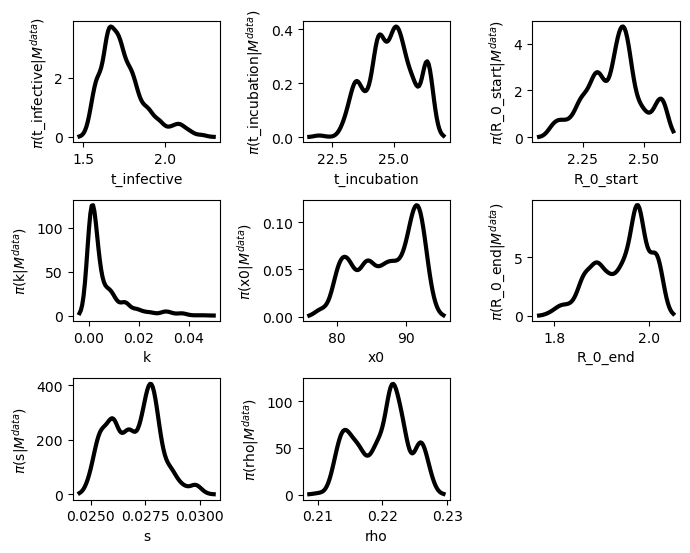

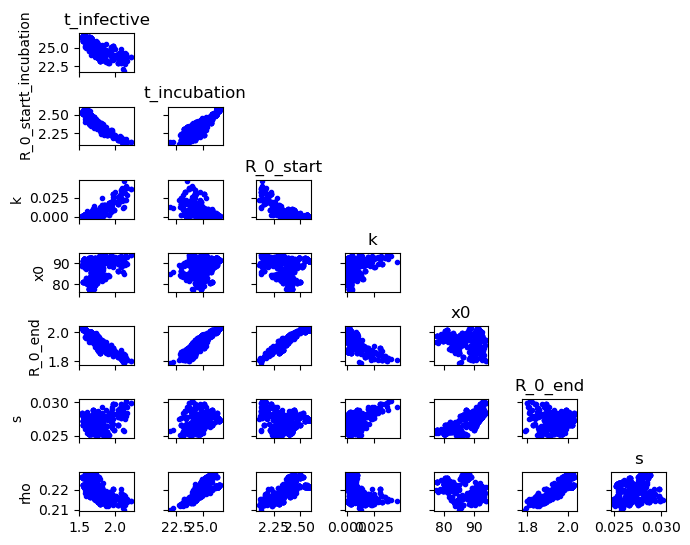

In [140]:
predictions= whole_covid(data, 7900000000)

In [141]:
r2_score(data['ACTIVE'], predictions)

0.94884693604335

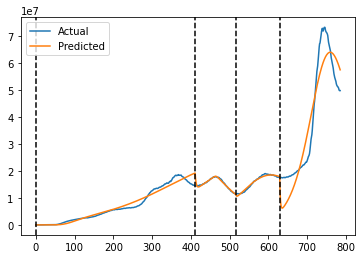

In [142]:
plt.plot(data['ACTIVE'], label = 'Actual')
plt.plot(predictions, label = 'Predicted')
for i in range(len(phases(active))):
    plt.axvline(x=phases(active)[i],color='k', linestyle='--')
plt.legend()

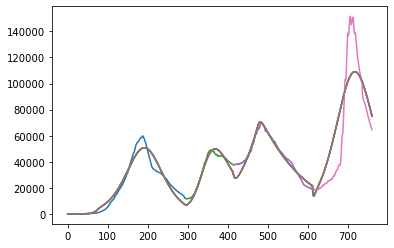

In [116]:
for i in range(len(phases(active))-1):
    plt.plot(data['ACTIVE'][phases(active)[i]:phases(active)[i+1]], label = 'Actual')
    plt.plot(predictions, label = 'Predicted')
plt.plot(data['ACTIVE'][phases(active)[-1]:], label = 'Actual')
plt.plot(predictions, label = 'Predicted')